In [16]:
!pip install matplotlib

     ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/11.6 MB 69.1 kB/s eta 0:02:19^C
     ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/11.6 MB 69.1 kB/s eta 0:02:19
ERROR: Operation cancelled by user


In [104]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
from catboost import CatBoostClassifier, CatBoostRegressor
from category_encoders.ordinal import OrdinalEncoder

import missingno as msno


In [2]:
INPUT_PATH = '../../input/'

test = pd.read_csv(INPUT_PATH + 'test.csv')
train = pd.read_csv(INPUT_PATH + 'train.csv')

train

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13174206,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887291,36.701026,483.0,273.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174207,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696070,141.493178,545.0,221.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174208,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912859,140.569205,611.0,217.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174209,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,232.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22


# 데이터 살펴보기

Columns 
- session_id - the ID of the session the event took place in
- index - the index of the event for the session
- elapsed_time - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
- event_name - the name of the event type
- name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
- level - what level of the game the event occurred in (0 to 22)
- page - the page number of the event (only for notebook-related events)
- room_coor_x - the coordinates of the click in reference to the in-game room (only for click events)
- room_coor_y - the coordinates of the click in reference to the in-game room (only for click events)
- screen_coor_x - the coordinates of the click in reference to the player’s screen (only for click events)
- screen_coor_y - the coordinates of the click in reference to the player’s screen (only for click events)
- hover_duration - how long (in milliseconds) the hover happened for (only for hover events)
- text - the text the player sees during this event
- fqid - the fully qualified ID of the event
- room_fqid - the fully qualified ID of the room the event took place in
- text_fqid - the fully qualified ID of the
- fullscreen - whether the player is in fullscreen mode
- hq - whether the game is in high-quality
- music - whether the game music is on or off
- level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

In [3]:
train_label = pd.read_csv(INPUT_PATH + 'train_labels.csv')
train_label

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1
3,20090314363702160_q1,1
4,20090314441803444_q1,1
...,...,...
212017,22100215342220508_q18,1
212018,22100215460321130_q18,1
212019,22100217104993650_q18,1
212020,22100219442786200_q18,1


In [4]:
train['session_id'].nunique()

11779

In [86]:
train_label['id'] = train_label['session_id'].apply(lambda x: int(x[:17]))

In [6]:
train_label['id'].nunique()

11779

In [7]:
train_label['session_id'].nunique()

212022

In [11]:
# id별 데이터 개수
train_byid = train.groupby('session_id').count()
train_byid

,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
session_id,,,,,,,,,,,,,,,,,,,
20090312431273200,881,881,881,881,881,0,813,813,813,813,65,384,652,881,384,0,0,0,881
20090312433251036,1831,1831,1831,1831,1831,59,1506,1506,1506,1506,322,410,1171,1831,410,0,0,0,1831
20090314121766812,1038,1038,1038,1038,1038,62,916,916,916,916,119,367,720,1038,367,0,0,0,1038
20090314363702160,1066,1066,1066,1066,1066,6,964,964,964,964,99,405,764,1066,405,0,0,0,1066
20090314441803444,789,789,789,789,789,0,696,696,696,696,90,337,619,789,337,0,0,0,789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,873,873,873,873,873,20,788,788,788,788,82,367,664,873,367,0,0,0,873
22100215460321130,985,985,985,985,985,21,862,862,862,862,120,432,793,985,432,0,0,0,985
22100217104993650,1199,1199,1199,1199,1199,67,1117,1117,1117,1117,79,427,788,1199,427,0,0,0,1199


In [14]:
train_byid['index'].plot.bar()

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

결측치 파악

In [25]:
train['hq']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
            ..
13174206   NaN
13174207   NaN
13174208   NaN
13174209   NaN
13174210   NaN
Name: hq, Length: 13174211, dtype: float64

<Axes: >

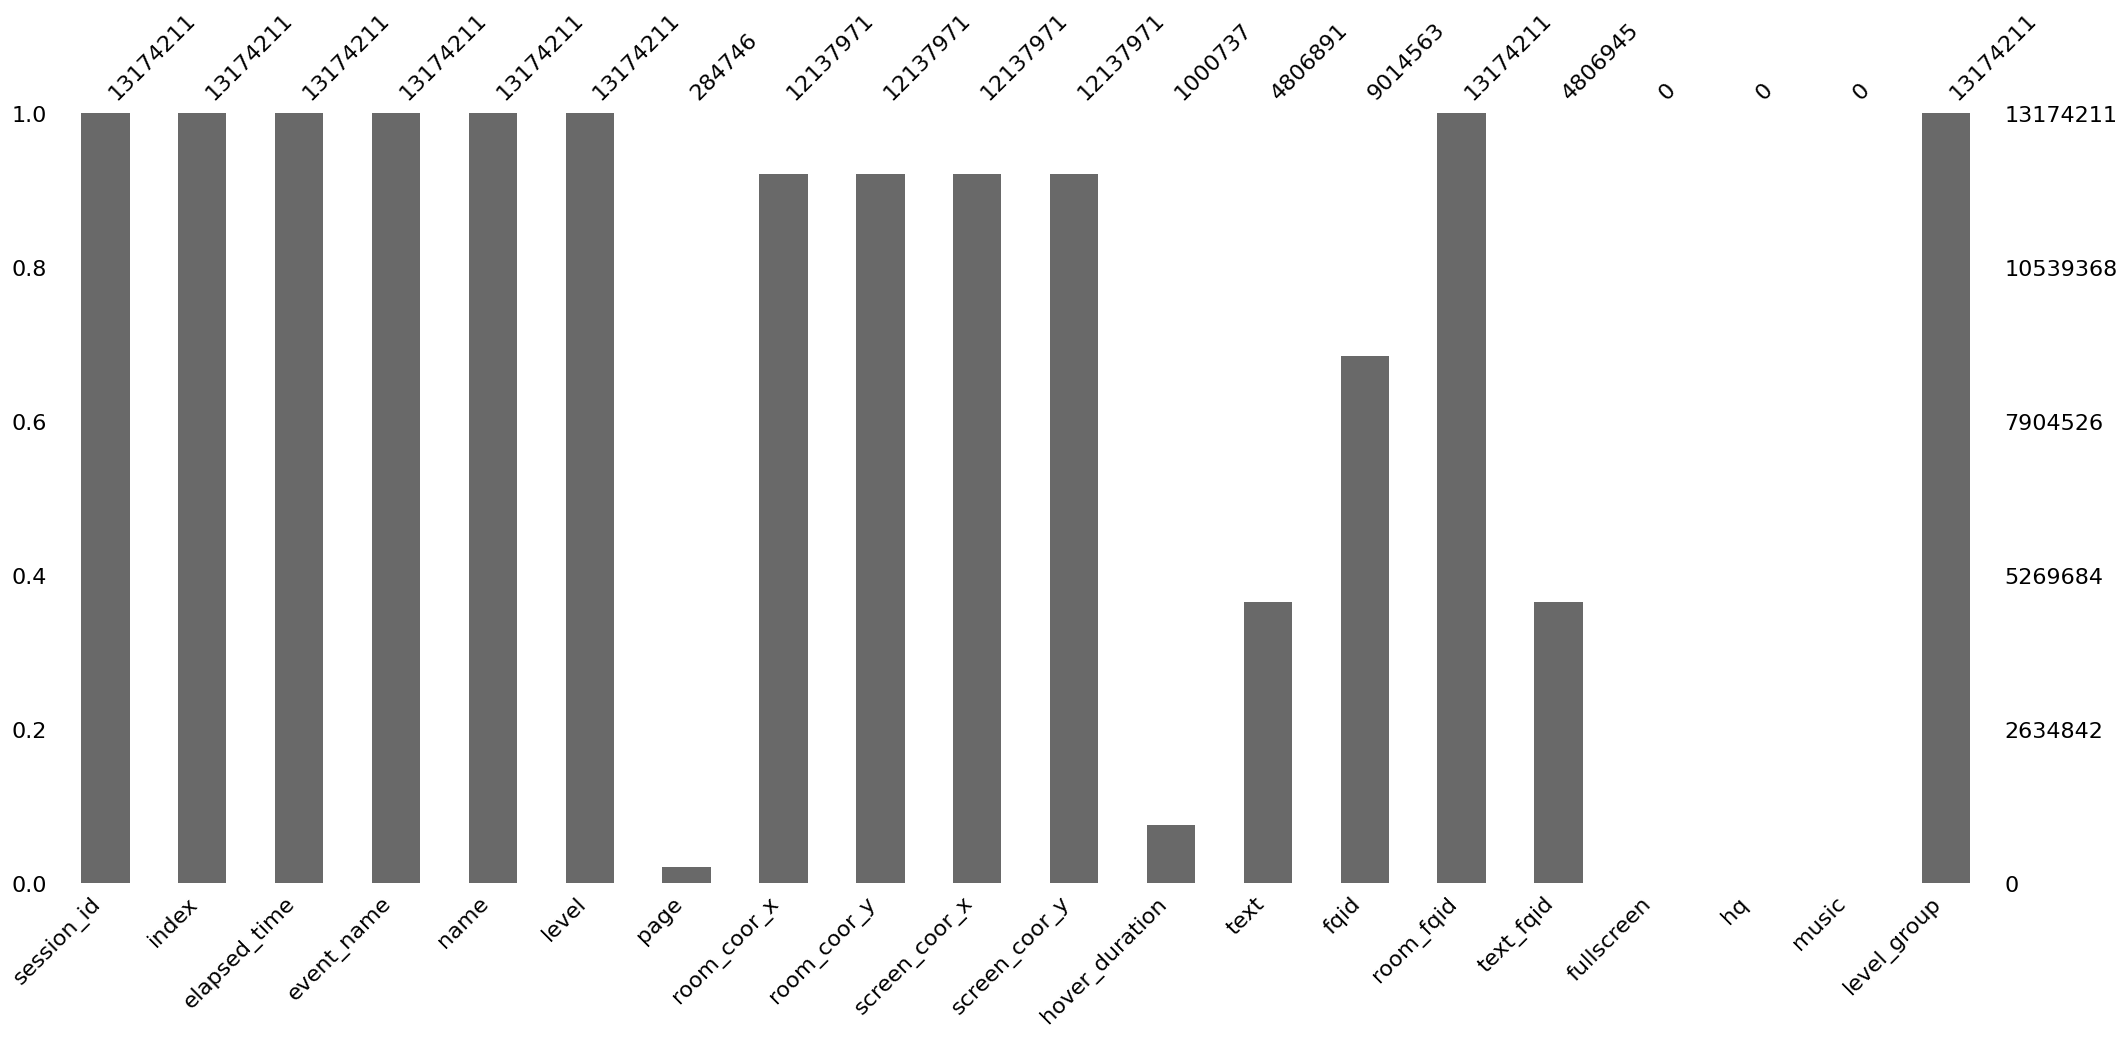

In [21]:
msno.bar(train)

In [26]:
train.columns

Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group'],
      dtype='object')

In [29]:
columns_withnan = [
    'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
    'hover_duration', 'text', 'fqid', 'text_fqid',
    'fullscreen', 'hq', 'music'
]

In [30]:
train_fullcol = train.loc[:, [col for col in train.columns if col not in columns_withnan]]
train_fullcol

,session_id,index,elapsed_time,event_name,name,level,room_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,tunic.historicalsociety.closet,0-4
1,20090312431273200,1,1323,person_click,basic,0,tunic.historicalsociety.closet,0-4
2,20090312431273200,2,831,person_click,basic,0,tunic.historicalsociety.closet,0-4
3,20090312431273200,3,1147,person_click,basic,0,tunic.historicalsociety.closet,0-4
4,20090312431273200,4,1863,person_click,basic,0,tunic.historicalsociety.closet,0-4
...,...,...,...,...,...,...,...,...
13174206,22100221145014656,1600,5483231,navigate_click,undefined,22,tunic.capitol_2.hall,13-22
13174207,22100221145014656,1601,5485166,navigate_click,undefined,22,tunic.capitol_2.hall,13-22
13174208,22100221145014656,1602,5485917,navigate_click,undefined,22,tunic.capitol_2.hall,13-22
13174209,22100221145014656,1603,5486753,navigate_click,undefined,22,tunic.capitol_2.hall,13-22


In [35]:
train_fullcol['elapsed_time'].value_counts()

0          11781
1014          67
1016          60
949           47
1032          46
           ...  
2828604        1
2827274        1
2823038        1
2822271        1
5487952        1
Name: elapsed_time, Length: 3804019, dtype: int64

In [37]:
submission = pd.read_csv(INPUT_PATH + 'sample_submission.csv')
submission.head()

,session_id,correct,session_level
0,20090109393214576_q1,0,20090109393214576_0-4
1,20090312143683264_q1,0,20090312143683264_0-4
2,20090312331414616_q1,0,20090312331414616_0-4
3,20090109393214576_q2,0,20090109393214576_0-4
4,20090312143683264_q2,0,20090312143683264_0-4


In [38]:
submission.loc[submission['session_id'].str.startswith('20090109393214576')]

,session_id,correct,session_level
0,20090109393214576_q1,0,20090109393214576_0-4
3,20090109393214576_q2,0,20090109393214576_0-4
6,20090109393214576_q3,0,20090109393214576_0-4
9,20090109393214576_q4,0,20090109393214576_5-12
12,20090109393214576_q5,0,20090109393214576_5-12
15,20090109393214576_q6,0,20090109393214576_5-12
18,20090109393214576_q7,0,20090109393214576_5-12
21,20090109393214576_q8,0,20090109393214576_5-12
24,20090109393214576_q9,0,20090109393214576_5-12
27,20090109393214576_q10,0,20090109393214576_5-12


In [128]:
train_label

,session_id,correct,id,question,session_level
0,20090312431273200_q1,1,20090312431273200,q1,0-4
1,20090312433251036_q1,0,20090312433251036,q1,0-4
2,20090314121766812_q1,1,20090314121766812,q1,0-4
3,20090314363702160_q1,1,20090314363702160,q1,0-4
4,20090314441803444_q1,1,20090314441803444,q1,0-4
...,...,...,...,...,...
212017,22100215342220508_q18,1,22100215342220508,q18,13-22
212018,22100215460321130_q18,1,22100215460321130,q18,13-22
212019,22100217104993650_q18,1,22100217104993650,q18,13-22
212020,22100219442786200_q18,1,22100219442786200,q18,13-22


: 

In [47]:
train.iloc[0]
train.loc[train['session_id'] == 20090312431273200, :][:100]

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,20090312431273200,95,98859,person_click,basic,2,NaN,277.753433,-166.585120,613.0,444.0,NaN,Could be. But we need evidence!,gramps,tunic.historicalsociety.collection,tunic.historicalsociety.collection.gramps.found,NaN,NaN,NaN,0-4
96,20090312431273200,96,99459,person_click,basic,2,NaN,368.432843,-176.661681,676.0,451.0,NaN,Why don't you head to the Basketball Center an...,gramps,tunic.historicalsociety.collection,tunic.historicalsociety.collection.gramps.found,NaN,NaN,NaN,0-4
97,20090312431273200,97,99958,person_click,basic,2,NaN,368.432120,-176.661922,676.0,451.0,NaN,Sure!,gramps,tunic.historicalsociety.collection,tunic.historicalsociety.collection.gramps.found,NaN,NaN,NaN,0-4
98,20090312431273200,98,100713,person_click,basic,2,NaN,400.098469,-176.662028,698.0,451.0,NaN,I'll be at the Capitol. Let me know if you fin...,gramps,tunic.historicalsociety.collection,tunic.historicalsociety.collection.gramps.found,NaN,NaN,NaN,0-4


In [51]:
train_label['session_id'].str.split('_')

0          [20090312431273200, q1]
1          [20090312433251036, q1]
2          [20090314121766812, q1]
3          [20090314363702160, q1]
4          [20090314441803444, q1]
                    ...           
212017    [22100215342220508, q18]
212018    [22100215460321130, q18]
212019    [22100217104993650, q18]
212020    [22100219442786200, q18]
212021    [22100221145014656, q18]
Name: session_id, Length: 212022, dtype: object

In [54]:
# level 에 따라 label 을 추가한다
# 0-4, 5-12, 13-22 에서의 정답률을 평균으로 구해서 이것을 라벨로 하자 (임시).
# q1 - q3 : 0-4,  
# q4 - q13 : 5-12,
# q14 - q18 : 13-22

def divide_level(q):
    if int(q[1:]) <= 3:
        return '0-4'
    elif int(q[1:]) <= 13:
        return '5-12'
    else:
        return '13-22'

train_label['question'] = train_label['session_id'].apply(lambda x: x.split('_')[-1])
train_label['session_level'] = train_label['question'].apply(divide_level)

train_label

,session_id,correct,id,question,session_level
0,20090312431273200_q1,1,20090312431273200,q1,0-4
1,20090312433251036_q1,0,20090312433251036,q1,0-4
2,20090314121766812_q1,1,20090314121766812,q1,0-4
3,20090314363702160_q1,1,20090314363702160,q1,0-4
4,20090314441803444_q1,1,20090314441803444,q1,0-4
...,...,...,...,...,...
212017,22100215342220508_q18,1,22100215342220508,q18,13-22
212018,22100215460321130_q18,1,22100215460321130,q18,13-22
212019,22100217104993650_q18,1,22100217104993650,q18,13-22
212020,22100219442786200_q18,1,22100219442786200,q18,13-22


In [89]:
rate_id_level = train_label.groupby(['id', 'session_level']).mean()
rate_id_level

/tmp/ipykernel_8632/1779019552.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rate_id_level = train_label.groupby(['id', 'session_level']).mean()


correct
id                session_level          
20090312431273200 0-4            1.000000
                  13-22          0.800000
                  5-12           0.900000
20090312433251036 0-4            0.666667
                  13-22          0.600000
...                                   ...
22100219442786200 13-22          0.800000
                  5-12           0.700000
22100221145014656 0-4            0.333333
                  13-22          0.400000
                  5-12           0.400000

[35337 rows x 1 columns]

In [66]:
rate_id_level.reset_index()

,id,session_level,correct
0,20090312431273200,0-4,1.000000
1,20090312431273200,13-22,0.800000
2,20090312431273200,5-12,0.900000
3,20090312433251036,0-4,0.666667
4,20090312433251036,13-22,0.600000
...,...,...,...
35332,22100219442786200,13-22,0.800000
35333,22100219442786200,5-12,0.700000
35334,22100221145014656,0-4,0.333333
35335,22100221145014656,13-22,0.400000


In [71]:
pd.concat?

Signature:
pd.concat(
    objs: 'Iterable[NDFrame] | Mapping[HashableT, NDFrame]',
    *,
    axis: 'Axis' = 0,
    join: 'str' = 'outer',
    ignore_index: 'bool' = False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity: 'bool' = False,
    sort: 'bool' = False,
    copy: 'bool' = True,
) -> 'DataFrame | Series'
Docstring:
Concatenate pandas objects along a particular axis.

Allows optional set logic along the other axes.

Can also add a layer of hierarchical indexing on the concatenation axis,
which may be useful if the labels are the same (or overlapping) on
the passed axis number.

Parameters
----------
objs : a sequence or mapping of Series or DataFrame objects
    If a mapping is passed, the sorted keys will be used as the `keys`
    argument, unless it is passed, in which case the values will be
    selected (see below). Any None objects will be dropped silently unless
    they are all None in which case a ValueError will be raised.
axis : {0/'index', 1/'col

In [81]:
train['level_group']

0             0-4
1             0-4
2             0-4
3             0-4
4             0-4
            ...  
13174206    13-22
13174207    13-22
13174208    13-22
13174209    13-22
13174210    13-22
Name: level_group, Length: 13174211, dtype: object

In [77]:
rate_id_level.reset_index()['session_level']

0          0-4
1        13-22
2         5-12
3          0-4
4        13-22
         ...  
35332    13-22
35333     5-12
35334      0-4
35335    13-22
35336     5-12
Name: session_level, Length: 35337, dtype: object

In [82]:
train[['session_id', 'level_group']]

,session_id,level_group
0,20090312431273200,0-4
1,20090312431273200,0-4
2,20090312431273200,0-4
3,20090312431273200,0-4
4,20090312431273200,0-4
...,...,...
13174206,22100221145014656,13-22
13174207,22100221145014656,13-22
13174208,22100221145014656,13-22
13174209,22100221145014656,13-22


In [85]:
train['session_id']

0           20090312431273200
1           20090312431273200
2           20090312431273200
3           20090312431273200
4           20090312431273200
                  ...        
13174206    22100221145014656
13174207    22100221145014656
13174208    22100221145014656
13174209    22100221145014656
13174210    22100221145014656
Name: session_id, Length: 13174211, dtype: int64

In [90]:
rate_id_level.reset_index()['id']

0        20090312431273200
1        20090312431273200
2        20090312431273200
3        20090312433251036
4        20090312433251036
               ...        
35332    22100219442786200
35333    22100219442786200
35334    22100221145014656
35335    22100221145014656
35336    22100221145014656
Name: id, Length: 35337, dtype: int64

In [83]:
rate_id_level.reset_index()[['id', 'session_level']]

,id,session_level
0,20090312431273200,0-4
1,20090312431273200,13-22
2,20090312431273200,5-12
3,20090312433251036,0-4
4,20090312433251036,13-22
...,...,...
35332,22100219442786200,13-22
35333,22100219442786200,5-12
35334,22100221145014656,0-4
35335,22100221145014656,13-22


In [95]:
train[:10]

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
5,20090312431273200,5,3423,person_click,basic,0,NaN,-412.991405,-157.314686,381.0,492.0,NaN,"Sure thing, Jo. Grab your notebook and come up...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
6,20090312431273200,6,5197,person_click,basic,0,NaN,478.485079,-199.971679,593.0,485.0,NaN,"See you later, Teddy.",teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,NaN,NaN,NaN,0-4
7,20090312431273200,7,6180,person_click,basic,0,NaN,503.355128,-168.619913,609.0,453.0,NaN,I get to go to Gramps's meeting!,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,NaN,NaN,NaN,0-4
8,20090312431273200,8,7014,person_click,basic,0,NaN,510.733442,-157.720642,615.0,442.0,NaN,Now where did I put my notebook?,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,NaN,NaN,NaN,0-4
9,20090312431273200,9,7946,person_click,basic,0,NaN,512.048005,-153.743631,616.0,438.0,NaN,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,NaN,NaN,NaN,0-4


In [93]:
# rate_id_level 을 바탕으로 target을 집어넣는다
train_with_target = train.merge(rate_id_level.reset_index(), left_on=['session_id', 'level_group'], right_on=['id', 'session_level']
)

train_with_target

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,id,session_level,correct
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4,20090312431273200,0-4,1.0
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090312431273200,0-4,1.0
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090312431273200,0-4,1.0
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090312431273200,0-4,1.0
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,...,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090312431273200,0-4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13174206,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887291,36.701026,483.0,...,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22,22100221145014656,13-22,0.4
13174207,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696070,141.493178,545.0,...,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22,22100221145014656,13-22,0.4
13174208,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912859,140.569205,611.0,...,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22,22100221145014656,13-22,0.4
13174209,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,...,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22,22100221145014656,13-22,0.4


In [102]:
# test의 session_id는 다르므로 일단은 학습과정에서 id를 빼야한다.
train_fullcol_noid = train_with_target.drop(columns=columns_withnan + ['session_id', 'id', 'session_level'])
train_fullcol_noid


,index,elapsed_time,event_name,name,level,room_fqid,level_group,correct
0,0,0,cutscene_click,basic,0,tunic.historicalsociety.closet,0-4,1.0
1,1,1323,person_click,basic,0,tunic.historicalsociety.closet,0-4,1.0
2,2,831,person_click,basic,0,tunic.historicalsociety.closet,0-4,1.0
3,3,1147,person_click,basic,0,tunic.historicalsociety.closet,0-4,1.0
4,4,1863,person_click,basic,0,tunic.historicalsociety.closet,0-4,1.0
...,...,...,...,...,...,...,...,...
13174206,1600,5483231,navigate_click,undefined,22,tunic.capitol_2.hall,13-22,0.4
13174207,1601,5485166,navigate_click,undefined,22,tunic.capitol_2.hall,13-22,0.4
13174208,1602,5485917,navigate_click,undefined,22,tunic.capitol_2.hall,13-22,0.4
13174209,1603,5486753,navigate_click,undefined,22,tunic.capitol_2.hall,13-22,0.4


In [99]:
test_fullcol = test.loc[:, [col for col in test.columns if col not in columns_withnan]]
test_fullcol

,session_id,index,elapsed_time,event_name,name,level,room_fqid,level_group,session_level
0,20090109393214576,0,0,cutscene_click,basic,0,tunic.historicalsociety.closet,0-4,20090109393214576_0-4
1,20090109393214576,1,1965,person_click,basic,0,tunic.historicalsociety.closet,0-4,20090109393214576_0-4
2,20090109393214576,2,3614,person_click,basic,0,tunic.historicalsociety.closet,0-4,20090109393214576_0-4
3,20090109393214576,3,5330,person_click,basic,0,tunic.historicalsociety.closet,0-4,20090109393214576_0-4
4,20090109393214576,4,6397,person_click,basic,0,tunic.historicalsociety.closet,0-4,20090109393214576_0-4
...,...,...,...,...,...,...,...,...,...
3723,20090312331414616,1001,1581679,map_hover,basic,22,tunic.historicalsociety.entry,13-22,20090312331414616_13-22
3724,20090312331414616,1002,1583044,map_hover,basic,22,tunic.historicalsociety.entry,13-22,20090312331414616_13-22
3725,20090312331414616,1003,1583410,map_click,undefined,22,tunic.historicalsociety.entry,13-22,20090312331414616_13-22
3726,20090312331414616,1004,1585841,navigate_click,undefined,22,tunic.capitol_2.hall,13-22,20090312331414616_13-22


In [ ]:
train_with_target.to_csv()

In [60]:
train[:10]

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
5,20090312431273200,5,3423,person_click,basic,0,NaN,-412.991405,-157.314686,381.0,492.0,NaN,"Sure thing, Jo. Grab your notebook and come up...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
6,20090312431273200,6,5197,person_click,basic,0,NaN,478.485079,-199.971679,593.0,485.0,NaN,"See you later, Teddy.",teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,NaN,NaN,NaN,0-4
7,20090312431273200,7,6180,person_click,basic,0,NaN,503.355128,-168.619913,609.0,453.0,NaN,I get to go to Gramps's meeting!,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,NaN,NaN,NaN,0-4
8,20090312431273200,8,7014,person_click,basic,0,NaN,510.733442,-157.720642,615.0,442.0,NaN,Now where did I put my notebook?,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,NaN,NaN,NaN,0-4
9,20090312431273200,9,7946,person_click,basic,0,NaN,512.048005,-153.743631,616.0,438.0,NaN,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,NaN,NaN,NaN,0-4


# 모델링

Catboost 이용

,index,elapsed_time,event_name,name,level,room_fqid,level_group
0,0,0,1,1,0,1,1
1,1,1323,2,1,0,1,1
2,2,831,2,1,0,1,1
3,3,1147,2,1,0,1,1
4,4,1863,2,1,0,1,1
...,...,...,...,...,...,...,...
13174206,1600,5483231,3,2,22,19,3
13174207,1601,5485166,3,2,22,19,3
13174208,1602,5485917,3,2,22,19,3
13174209,1603,5486753,3,2,22,19,3


In [106]:
test_fullcol_noid = test.drop(columns=columns_withnan + ['session_id', 'session_level'])
test_fullcol_noid

,index,elapsed_time,event_name,name,level,room_fqid,level_group
0,0,0,cutscene_click,basic,0,tunic.historicalsociety.closet,0-4
1,1,1965,person_click,basic,0,tunic.historicalsociety.closet,0-4
2,2,3614,person_click,basic,0,tunic.historicalsociety.closet,0-4
3,3,5330,person_click,basic,0,tunic.historicalsociety.closet,0-4
4,4,6397,person_click,basic,0,tunic.historicalsociety.closet,0-4
...,...,...,...,...,...,...,...
3723,1001,1581679,map_hover,basic,22,tunic.historicalsociety.entry,13-22
3724,1002,1583044,map_hover,basic,22,tunic.historicalsociety.entry,13-22
3725,1003,1583410,map_click,undefined,22,tunic.historicalsociety.entry,13-22
3726,1004,1585841,navigate_click,undefined,22,tunic.capitol_2.hall,13-22


In [126]:
import pickle

In [127]:
with open('../models/encoder_ord_230320.pkl', 'wb') as f:
    pickle.dump(ord, f)

In [114]:
# 학습
X_train = train_fullcol_noid.drop(columns=['correct'])
y_train = train_fullcol_noid[['correct']]

# ordinalencoder 이용
ord = OrdinalEncoder(cols=['event_name', 'name', 'room_fqid', 'level_group'])
X_train_ord = ord.fit_transform(X_train) 

model_cat = CatBoostRegressor()
model_cat.fit(X_train_ord[:1000], y_train[:1000])

# 추론
test_ord = ord.transform(test_fullcol_noid)
y_pred = model_cat.predict(test_ord)


Learning rate set to 0.040943
0:	learn: 0.0956303	total: 7.21ms	remaining: 7.2s
1:	learn: 0.0942398	total: 9.08ms	remaining: 4.53s
2:	learn: 0.0927259	total: 10.9ms	remaining: 3.63s
3:	learn: 0.0912767	total: 12.9ms	remaining: 3.21s
4:	learn: 0.0901325	total: 14.7ms	remaining: 2.93s
5:	learn: 0.0887810	total: 16.6ms	remaining: 2.75s
6:	learn: 0.0875421	total: 18.5ms	remaining: 2.62s
7:	learn: 0.0861141	total: 20.4ms	remaining: 2.54s
8:	learn: 0.0852884	total: 22.4ms	remaining: 2.46s
9:	learn: 0.0842877	total: 24.2ms	remaining: 2.39s
10:	learn: 0.0833463	total: 26.1ms	remaining: 2.35s
11:	learn: 0.0822193	total: 28ms	remaining: 2.31s
12:	learn: 0.0813630	total: 29.4ms	remaining: 2.23s
13:	learn: 0.0805212	total: 30.6ms	remaining: 2.16s
14:	learn: 0.0795544	total: 31.9ms	remaining: 2.09s
15:	learn: 0.0789102	total: 33.2ms	remaining: 2.04s
16:	learn: 0.0780987	total: 34.1ms	remaining: 1.97s
17:	learn: 0.0774000	total: 35.2ms	remaining: 1.92s
18:	learn: 0.0764851	total: 36.1ms	remaining: 1

In [121]:
model_cat.predict(test_ord.iloc[100])

0.6391193555201132

In [122]:
os.getcwd()

'/home/wooseok/Python_lab/kaggle/gameplay/student-gameplay-prediction/notebooks'

In [124]:
model_cat.save_model('../models/catboost_230320_1.pt')

In [125]:
model2 = CatBoostRegressor().load_model('../models/catboost_230320_1.pt')
model2

DKT models

# 제출